# **Implementación en _Qiskit_ 1.0.2 del algoritmo de Shor. Análisis del circuito**

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, qiskit
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
import numpy as np
from fractions import Fraction
from qiskit.circuit.library import QFT
from time import time

In [2]:
# Versión de Qiskit con la que trabajaremos
qiskit.__version__

'1.0.2'

Este documento pretende implementar el código necesario para la creación y el análisis del circuito correspondiente a la parte cuántica del algoritmo de Shor. Particularizaremos a $N=21$ y $x = 2$, de donde $\text{mcd}(x,N)=1$. Queremos entonces estimar el orden multiplicativo de 2 módulo 21. Para la exponenciación modular, nos servimos del siguiente código:

In [3]:
def exp_mod21(potencia):
    power = potencia
    qreg = QuantumRegister(5)
    exp_mod = QuantumCircuit(qreg, name='mod_ex')
    
    # x^power mod N
    exp_mod.cswap(0, 3, 4)
    exp_mod.cswap(0, 1, 2)
    exp_mod.cx(4, 2)
    exp_mod.cx(4, 0)
    exp_mod.swap(3, 4)
    exp_mod.swap(0, 3)
    exp_mod.swap(2, 3)
    exp_mod.swap(1, 2)
    
    # Si quisiéramos agilizar el proceso podemos añadir la instrucción de abajo. Esto se puede hacer si conocemos el orden de antemano
    #power = power % 6

    # Aplicacion reiterada
    circreg = QuantumRegister(5, name='q')
    circ = QuantumCircuit(circreg, name='2^' + str(power) + ' mod 21')

    if power == 0:
        return circ.id()
    else:
        for i in range(power):
            circ.append(exp_mod.to_gate(), [i for i in range(5)])
        return circ

Veamos cuál es el circuito dentro de la puerta a controlar en el algoritmo.

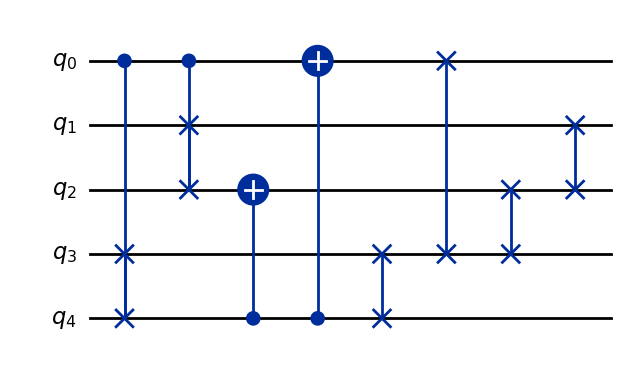

In [4]:
puerta_exp_mod = exp_mod21(1).decompose()
display(puerta_exp_mod.draw("mpl"))

Si realizamos un transpilado al _backend_ que emplearemos para la simulación ($\verb|qasm_simulator|$), observamos que no es necesario descomponer el circuito en puertas más elementales para su implementación.

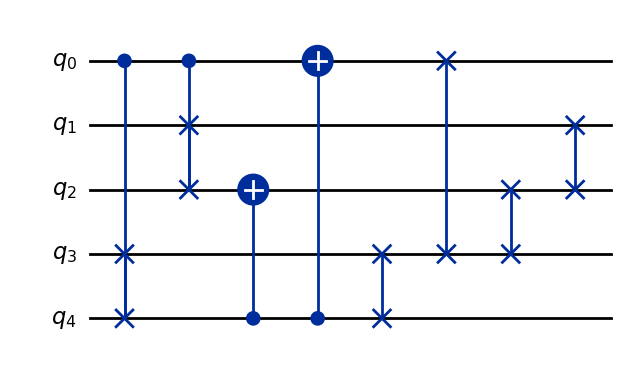

In [5]:
backend = Aer.get_backend("qasm_simulator")
puerta_exp_mod_t = transpile(puerta_exp_mod,backend)
display(puerta_exp_mod_t.draw("mpl"))

Podemos entonces analizar la profundidad y el número de puertas con el siguiente código:

In [6]:
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in puerta_exp_mod_t.count_ops().items():
    print(f"{k:<18} {v}")
print(f"\nEl circuito tiene un total de {sum(puerta_exp_mod_t.count_ops().values())} puertas.")
print(f"El circuito tiene una profundidad de {puerta_exp_mod_t.depth()}.")

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número
swap               4
cswap              2
cx                 2

El circuito tiene un total de 8 puertas.
El circuito tiene una profundidad de 8.


Apliquemos esta puerta para el circuito que nos ocupa. En primer lugar, debemos inicializar las variables $N$ y $x$ de acuerdo al contexto en el que estamos.

In [7]:
# Inicializamos N y x
N = 21
x = 2

A continuación se crea el circuito correspondiente a la parte cuántica del algoritmo de Shor:

Tiempo de creación del circuito: 4.055615186691284 segundos.


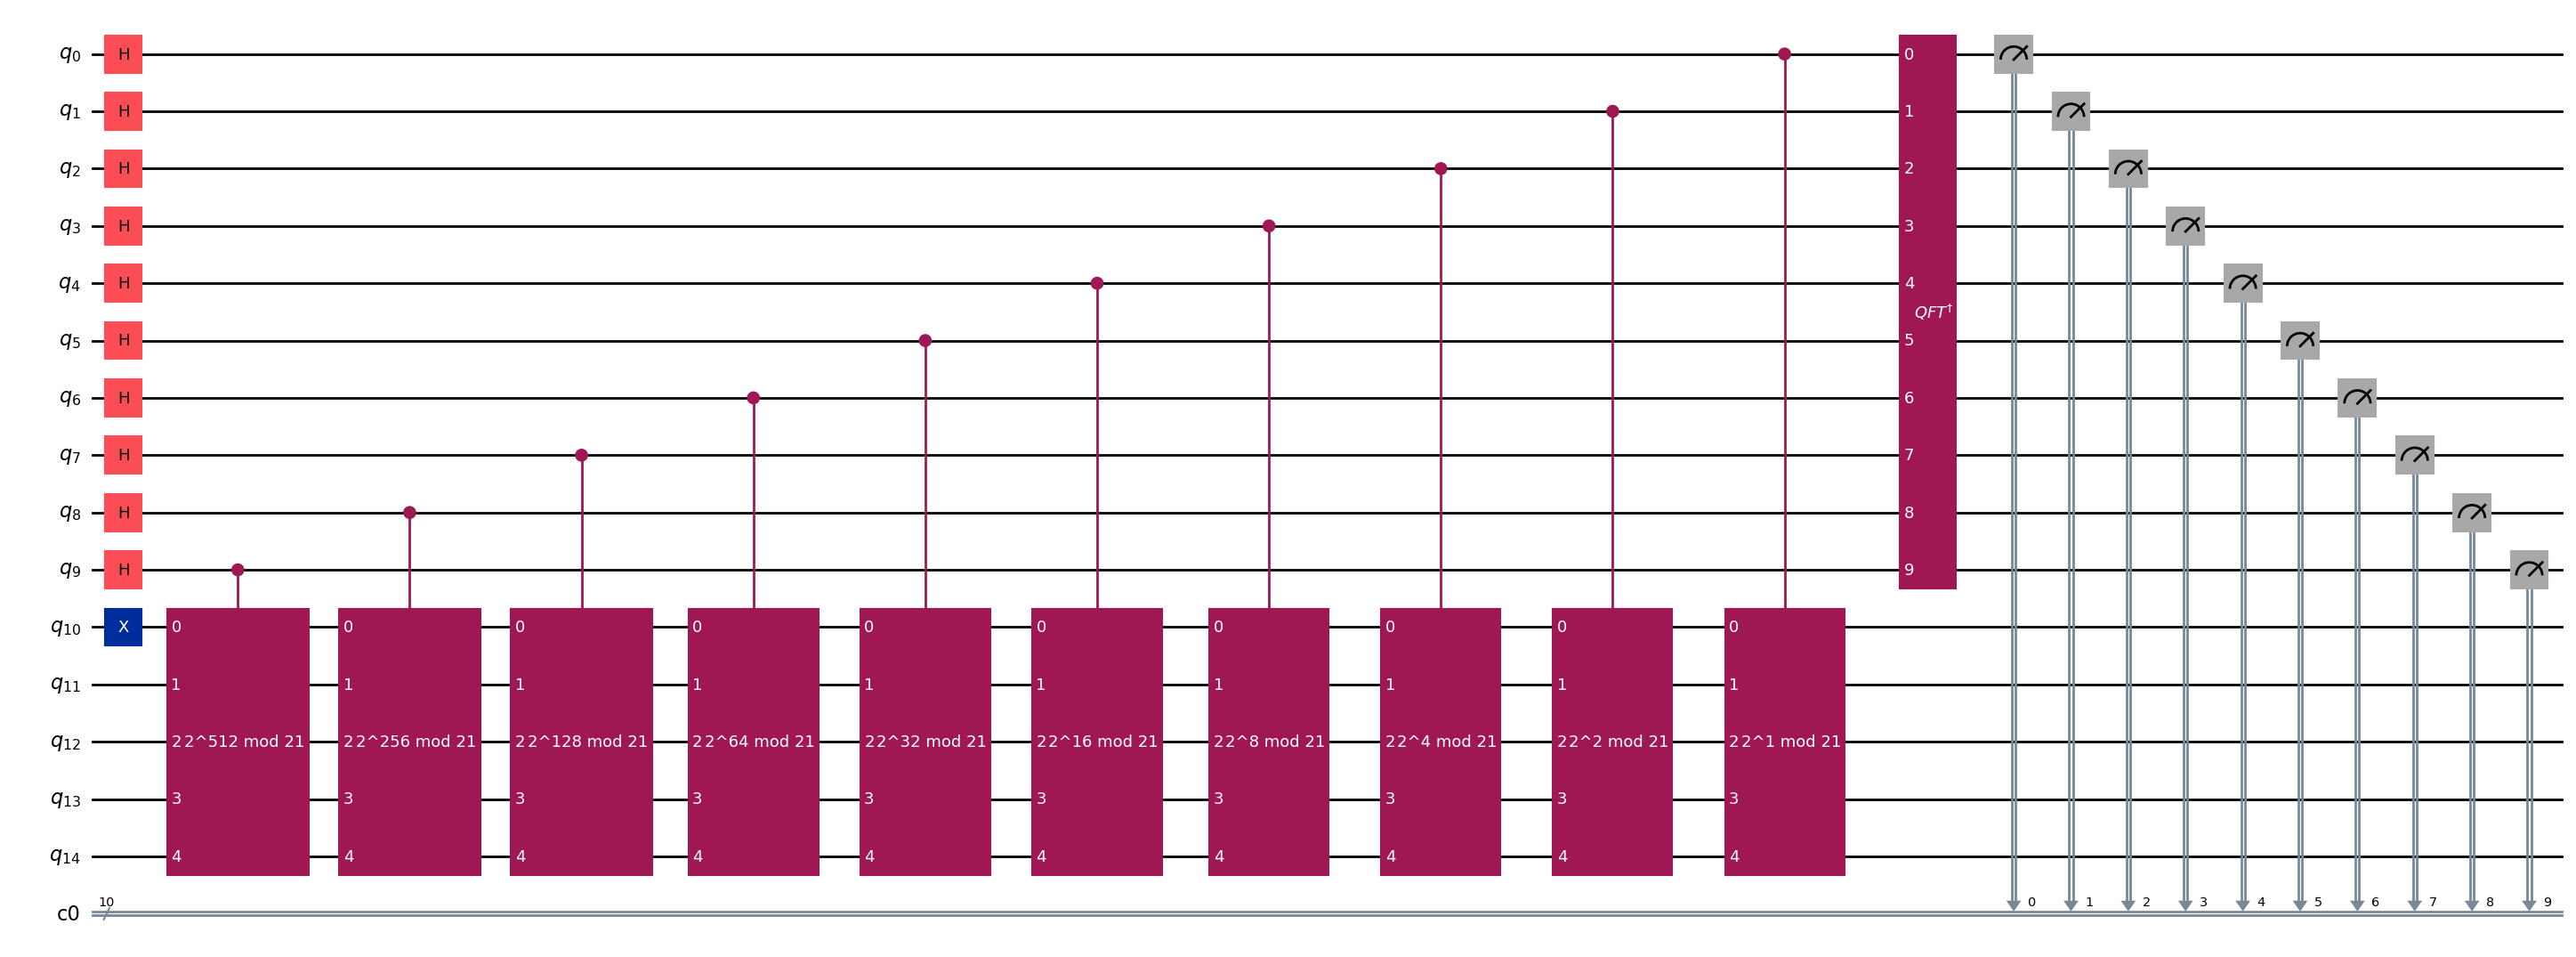

In [8]:
# Parte cuántica del algoritmo de Shor. Implementación en Qiskit 1.0.2
t0 = time() # Inicio de la construcción del circuito
# Calculamos los qubits necesarios
n_in_qubits = int(np.ceil(np.log2(N)))
n_out_qubits = 2*n_in_qubits
n_qubits = n_out_qubits + n_in_qubits

# Circuito de Shor
shor_qreg = QuantumRegister(n_qubits, name='q')
shor_creg = ClassicalRegister(n_out_qubits)

shor_circ = QuantumCircuit(shor_qreg,shor_creg,name="Shor")

# Puertas hadamard a los 'n_in_qubits' qubits del registro de estimación
shor_circ.h(range(n_out_qubits))

# Puerta X al qubit menos significativo del registro del autovector
shor_circ.x(n_out_qubits)

# Puertas de exponeciación modular controladas
for i in range(n_out_qubits):
    shor_circ.append(exp_mod21(2**(n_out_qubits - 1 - i)).control(1),[n_out_qubits - 1 - i] + [j for j in list(range(n_out_qubits,n_qubits)) ])

# Transformada de Fourier cuántica inversa
shor_circ.append(QFT(n_out_qubits,inverse=True, name='$QFT^{\dagger}$'),[j for j in range(n_out_qubits)])

# Medidas
shor_circ.measure([shor_qreg[i] for i in range(n_out_qubits-1,-1,-1)],[shor_creg[ n_out_qubits - 1 - i] for i in range(n_out_qubits)])

# Tiempo de creación
t1 = time()-t0
print("Tiempo de creación del circuito:",t1,"segundos.")

# Mostramos el circuito descomponiendo únicamente las puertas controladas por comodidad visual
display(shor_circ.decompose(gates_to_decompose=['c_2^' + str(power) + ' mod 21' for power in [2**i for i in range(n_out_qubits)]]).draw("mpl",fold=-1))

Para revisar que el circuito es adecuado, ejecutémoslo (realizaremos 10000 _shots_), y filtremos los resultados.

Tiempo de transpilado a simulador: 4.2750232219696045 segundos.
Tiempo de ejecución en simulador: 2.5432422161102295 segundos.


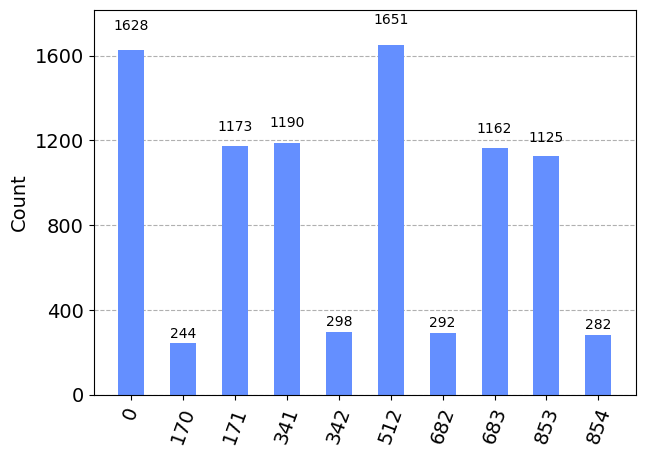

In [9]:
# Ejecución en simulador
backend = Aer.get_backend("qasm_simulator")
t0 = time() # Tiempo de inicio. Obviamos el obtener un backend
shor_circ_t = transpile(shor_circ,backend)
t_transpile = time() # Fin de transpilado
result = backend.run(shor_circ_t,shots = 10000).result()
t_result = time() # Fin de ejecución

print("Tiempo de transpilado a simulador:",t_transpile - t0,"segundos.")
print("Tiempo de ejecución en simulador:",t_result-t_transpile,"segundos.")

# Filtramos los resultados a aquellos superando el 1 por ciento de los shots realizados
counts_dec = {int(v,2):k for v,k in result.get_counts().items() if k > 0.01*10000}

# Histograma filtrado
display(plot_histogram(counts_dec))

En efecto, si hacemos uso de la teoría de las fracciones continuas podemos deducir el orden multiplicativo. En el siguiente código se muestra cómo.

In [10]:
# Calculamos todos los posibles periodos
for i in sorted(counts_dec):
    convergente = Fraction(i,2**n_out_qubits).limit_denominator(N)
    print(f"La medida es {str(i)} la convergente es {str(convergente)}. Periodo {str(convergente.denominator)}.")

La medida es 0 la convergente es 0. Periodo 1.
La medida es 170 la convergente es 1/6. Periodo 6.
La medida es 171 la convergente es 1/6. Periodo 6.
La medida es 341 la convergente es 1/3. Periodo 3.
La medida es 342 la convergente es 1/3. Periodo 3.
La medida es 512 la convergente es 1/2. Periodo 2.
La medida es 682 la convergente es 2/3. Periodo 3.
La medida es 683 la convergente es 2/3. Periodo 3.
La medida es 853 la convergente es 5/6. Periodo 6.
La medida es 854 la convergente es 5/6. Periodo 6.


El orden es 6, tal y como esperábamos. Aprovechando que hemos transpilado el circuito anterior, analicemos este.

In [11]:
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in shor_circ_t.count_ops().items():
    print(f"{k:<18} {v}")
print(f"\nEl circuito tiene un total de {sum(shor_circ_t.count_ops().values())} puertas.")
print(f"El circuito tiene una profundidad de {shor_circ_t.depth()}.")

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número
ccx                30690
u                  28644
cx                 28644
cu                 4092
cp                 45
h                  20
measure            10
swap               5
p                  3
x                  1

El circuito tiene un total de 92154 puertas.
El circuito tiene una profundidad de 85955.


La cantidad de puertas y la profundidad del circuito son considerables. A la hora de factorizar enteros cuyos $n$ asociados sean mayores o iguales a 6, el aumento de recursos necesarios degrada la eficiencia del circuito. A modo de ejercicio, se representará $N = 21$ con 6 _bits_ en lugar de 5. Por la orientación escogida, el registro del autovector tendrá una línea adicional abajo del todo, a cuyo _qubit_ no es necesario aplicar puerta alguna. No obstante, definiremos una nueva puerta para la exponenciación modular.

In [12]:
def exp_mod21_aumentado(potencia):
    power = potencia
    qreg = QuantumRegister(6)
    exp_mod = QuantumCircuit(qreg, name='mod_ex')
    
    # x^power mod N
    exp_mod.cswap(0, 3, 4)
    exp_mod.cswap(0, 1, 2)
    exp_mod.cx(4, 2)
    exp_mod.cx(4, 0)
    exp_mod.swap(3, 4)
    exp_mod.swap(0, 3)
    exp_mod.swap(2, 3)
    exp_mod.swap(1, 2)
    
    # Si quisiéramos agilizar el proceso podemos añadir la instrucción de abajo. Esto se puede hacer si conocemos el orden de antemano
    #power = power % 6

    # Aplicacion reiterada
    circreg = QuantumRegister(6, name='q')
    circ = QuantumCircuit(circreg, name='2^' + str(power) + ' mod 21')

    if power == 0:
        return circ.id()
    else:
        for i in range(power):
            circ.append(exp_mod.to_gate(), [i for i in range(6)])
        return circ

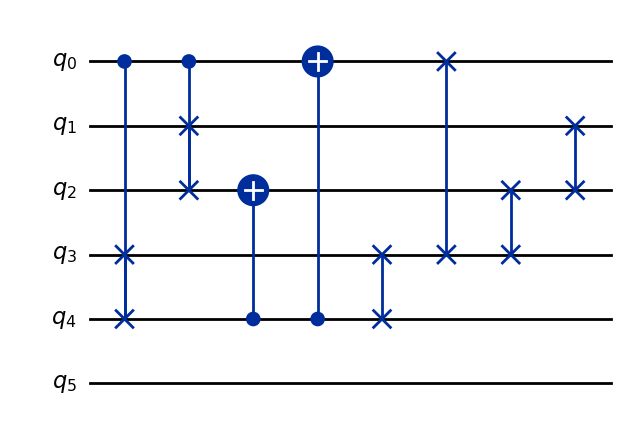

In [13]:
exp_mod21_aumentado(1).decompose().draw("mpl")

Estudiemos cómo afecta esta decisión en los tiempos anteriormente vistos.

Tiempo de creación del circuito: 17.992271184921265 segundos.


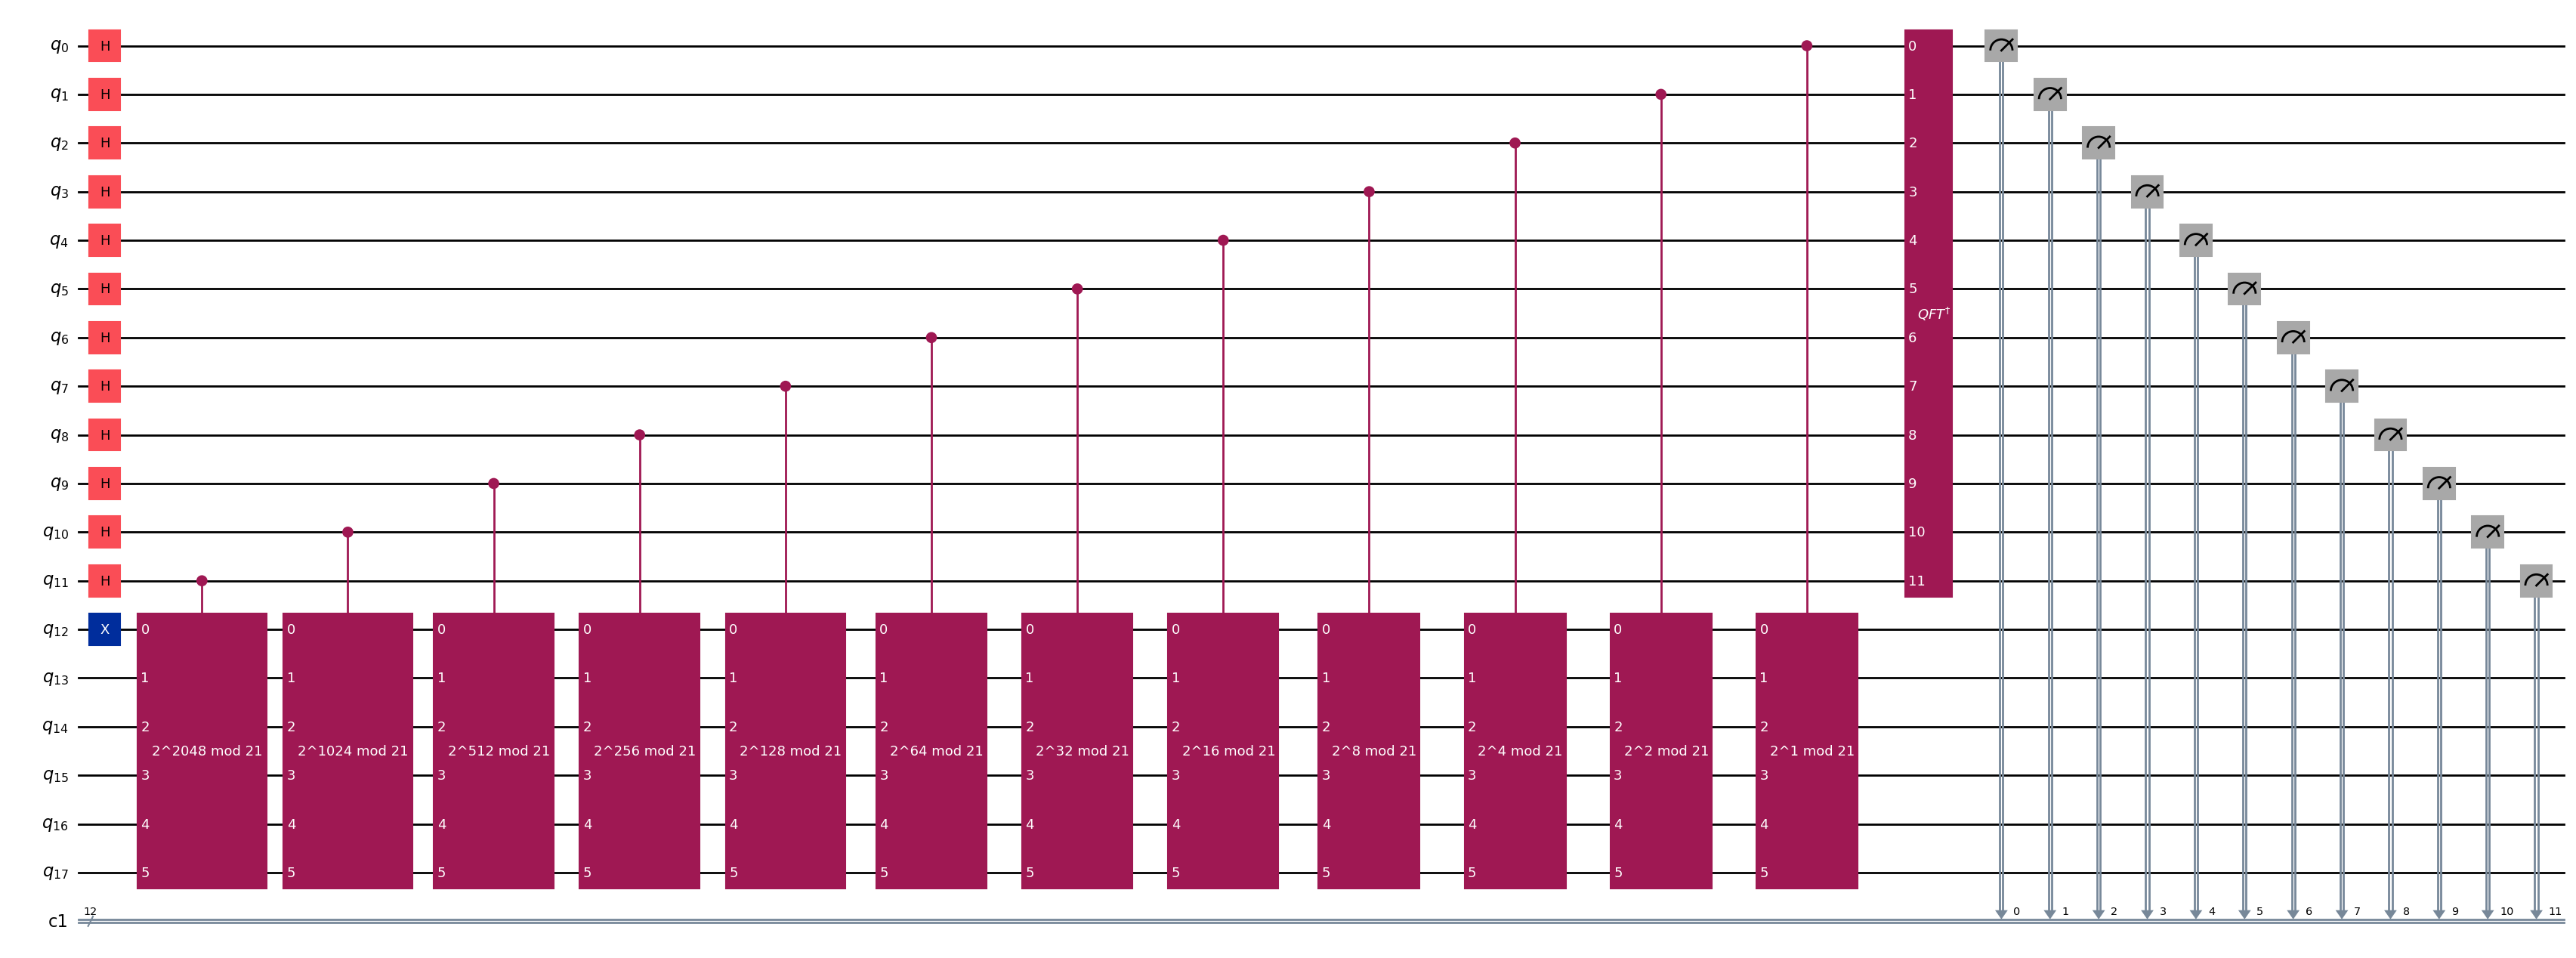

In [14]:
# Parte cuántica del algoritmo de Shor. Implementación en Qiskit 1.0.2
t0 = time() # Inicio de la construcción del circuito
# Calculamos los qubits necesarios
n_in_qubits = int(np.ceil(np.log2(N))) + 1 # Aumento en 1 del número de bits para la representación de N
n_out_qubits = 2*n_in_qubits
n_qubits = n_out_qubits + n_in_qubits

# Circuito de Shor
shor_qreg = QuantumRegister(n_qubits, name='q')
shor_creg = ClassicalRegister(n_out_qubits)

shor_circ_aumentado = QuantumCircuit(shor_qreg,shor_creg,name="Shor_aumentado")

# Puertas hadamard a los 'n_in_qubits' qubits del registro de estimación
shor_circ_aumentado.h(range(n_out_qubits))

# Puerta X al qubit menos significativo del registro del autovector
shor_circ_aumentado.x(n_out_qubits)

# Puertas de exponeciación modular controladas
for i in range(n_out_qubits):
    shor_circ_aumentado.append(exp_mod21_aumentado(2**(n_out_qubits - 1 - i)).control(1),[n_out_qubits - 1 - i] + [j for j in list(range(n_out_qubits,n_qubits)) ])

# Transformada de Fourier cuántica inversa
shor_circ_aumentado.append(QFT(n_out_qubits,inverse=True, name='$QFT^{\dagger}$'),[j for j in range(n_out_qubits)])

# Medidas
shor_circ_aumentado.measure([shor_qreg[i] for i in range(n_out_qubits-1,-1,-1)],[shor_creg[ n_out_qubits - 1 - i] for i in range(n_out_qubits)])

# Tiempo de creación
t1 = time()-t0
print("Tiempo de creación del circuito:",t1,"segundos.")

# Para mostrar el circuito como antes descomentar la línea de código siguiente
display(shor_circ_aumentado.decompose(gates_to_decompose=['c_2^' + str(power) + ' mod 21' for power in [2**i for i in range(n_out_qubits)]]).draw("mpl",fold=-1))

Tiempo de transpilado a simulador: 19.644176721572876 segundos.
Tiempo de ejecución en simulador: 12.604357242584229 segundos.


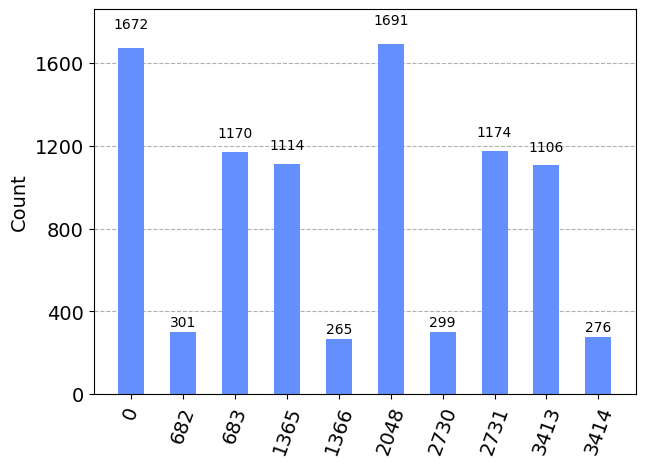

In [15]:
# Ejecución en simulador
backend = Aer.get_backend("qasm_simulator")
t0 = time() # Tiempo de inicio. Obviamos el obtener un backend
shor_circ_aumentado_t = transpile(shor_circ_aumentado,backend)
t_transpile = time() # Fin de transpilado
result = backend.run(shor_circ_aumentado_t,shots = 10000).result()
t_result = time() # Fin de ejecución

print("Tiempo de transpilado a simulador:",t_transpile - t0,"segundos.")
print("Tiempo de ejecución en simulador:",t_result-t_transpile,"segundos.")

# Filtramos los resultados a aquellos superando el 1 por ciento de los shots realizados
counts_dec = {int(v,2):k for v,k in result.get_counts().items() if k > 0.01*10000}

# Histograma filtrado
display(plot_histogram(counts_dec))

Como podemos observar, los tiempos de creación, transpilado y ejecución del circuito se ven incrementados sustancialmente. Los resultados siguen ofreciéndonos el orden multiplicativo que buscamos. Recordemos que estos deben adaptarse al aumento de la precisión.

In [16]:
# Calculamos todos los posibles periodos
for i in sorted(counts_dec):
    convergente = Fraction(i,2**n_out_qubits).limit_denominator(N)
    print(f"La medida es {str(i)} la convergente es {str(convergente)}. Periodo {str(convergente.denominator)}.")

La medida es 0 la convergente es 0. Periodo 1.
La medida es 682 la convergente es 1/6. Periodo 6.
La medida es 683 la convergente es 1/6. Periodo 6.
La medida es 1365 la convergente es 1/3. Periodo 3.
La medida es 1366 la convergente es 1/3. Periodo 3.
La medida es 2048 la convergente es 1/2. Periodo 2.
La medida es 2730 la convergente es 2/3. Periodo 3.
La medida es 2731 la convergente es 2/3. Periodo 3.
La medida es 3413 la convergente es 5/6. Periodo 6.
La medida es 3414 la convergente es 5/6. Periodo 6.


Finalmente, el número de puertas y la profundidad que presenta el nuevo circuito se muestra a continuación.

In [17]:
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in shor_circ_aumentado_t.count_ops().items():
    print(f"{k:<18} {v}")
print(f"\nEl circuito tiene un total de {sum(shor_circ_aumentado_t.count_ops().values())} puertas.")
print(f"El circuito tiene una profundidad de {shor_circ_aumentado_t.depth()}.")

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número
ccx                122850
u                  114660
cx                 114660
cu                 16380
cp                 66
h                  24
measure            12
swap               6
p                  4
x                  1

El circuito tiene un total de 368663 puertas.
El circuito tiene una profundidad de 344007.
